In [1]:
import sys
sys.path.append("/home/vdrame/catkin_ws/src/fruit_packaging/robosuite")
import robosuite
from robosuite.controllers import load_controller_config
from robosuite.utils.input_utils import *
import cv2
import matplotlib.cm as cm
from robosuite.utils.camera_utils import get_real_depth_map, get_camera_intrinsic_matrix, get_camera_extrinsic_matrix

import robosuite.utils.transform_utils as T
from PyLQR.sim import KDLRobot
from PyLQR.system import PosOrnPlannerSys, PosOrnKeypoint
from PyLQR.solver import BatchILQRCP, BatchILQR, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from robosuite.wrappers import VisualizationWrapper

from tqdm import tqdm

from robosuite.utils.transform_utils import convert_quat, mat2quat

import logging
import cv2
import numpy as np
# sys.path.append("/home/vdrame/catkin_ws/src/contact_grasp/src/contact_grasp")
# from contact_grasp.contact_grasp import grasps_generator

from scipy.spatial.transform import Rotation


import rospy
from contact_grasp.srv import contactGraspnetPointcloud2, contactGraspnetPointcloud2Response
from contact_grasp.data import depth2pc
from contact_grasp.transform_utils import pose_inv

from cv_bridge import CvBridge, CvBridgeError
from sensor_msgs import point_cloud2
from sensor_msgs.msg import PointField
from std_msgs.msg import Header

import open3d as o3d

Unable to load module hid, required to interface with SpaceMouse.

           Only macOS is officially supported. Install the additional

           requirements with `pip install -r requirements-extra.txt`
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def segmentation_to_rgb(seg_im):
    """
    Helper function to visualize segmentations as RGB frames.
    NOTE: assumes that geom IDs go up to 255 at most - if not,
    multiple geoms might be assigned to the same color.
    """
    # ensure all values lie within [0, 255]
    seg_im = np.mod(seg_im, 256).astype(np.uint8)
    # deterministic shuffling of values to map each geom ID to a random int in [0, 255]
    rstate = np.random.RandomState(seed=8)
    inds = np.arange(256)
    rstate.shuffle(inds)
    # use @inds to map each geom ID to a color
    return (255.0 * cm.rainbow(inds[seg_im], 3)).astype(np.uint8)[..., :3]


def get_cam_views(env, cam_name, seg_type=None, object_range=[5,8], noise_std = 0.0025):
    obs = env.observation_spec()

    img = obs[f"{cam_name}_image"].copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if seg_type:
        segmap = obs[f"{cam_name}_segmentation_{seg_type}"].copy()
        segmap = segmap.squeeze(-1)

        segmap = segmap - (min(object_range) - 1)
        segmap = np.where((segmap <= 0), 0, segmap)
        segmap = np.where((segmap > max(object_range) - min(object_range) + 1), 0, segmap).astype(np.float32)
        #segmap[:, 120:] = 0
    else:
        segmap=None

    depth = obs[f"{cam_name}_depth"].copy()
    depth = get_real_depth_map(env.sim, depth).squeeze(-1)
    depth += np.random.normal(0, noise_std, size=(256, 256))
    
    return img, depth, segmap

def keypress_callback(key, env):
    terminate_render = False
    opening = True
    if key >= ord('1') and key <= ord('5'):
        # toggle between camera 1 and 5
        env.viewer.set_camera(camera_id=key - ord('1'))
    elif key == ord("o"):
        opening = True
    elif key == ord("c"):
        opening = False

    if key == ord('q'):
        
        terminate_render = True

    return terminate_render, opening

def show_camera_view(rgb, depth, segmap, segmentation_type=None):

    if segmentation_type is not None:
        segmap = segmentation_to_rgb(segmap)

    cv2.imshow("RGB image", rgb)
    if segmentation_type is not None:
        cv2.imshow("segmentation map", segmap)
    cv2.imshow("depth", (255*(depth-depth.min()) /
                depth.max()).astype(np.uint8))
    cv2.waitKey(25)

def run_sim(env, actions, eef_pos=None, eef_quat=None, segmentation_type=None, show_agentview=False, object_range=[5,8]):
    success = False
    for idx, action in enumerate(actions):
        obs, reward, done, _ = env.step(action)
        #env.sim.step()
        if eef_pos is not None:
            eef_pos.append(obs['robot0_eef_pos'])
        if eef_quat is not None:
            eef_quat.append(obs['robot0_eef_quat'])

        key = cv2.waitKey(1)
        break_sim, opening = keypress_callback(key, env)
        env.render()
        if break_sim:
            return success, idx

        if show_agentview==True:
            img, depth, segmap = get_cam_views(env, "agentview", segmentation_type, object_range=object_range)
            show_camera_view(img, depth, segmap, segmentation_type)

    success = True
    return success, idx

def check_KDL_robosuite_alignement(env, rbt):
    # initial joint config
    q0 = env.robots[0]._joint_positions
    dq0 = [0]*panda_robot.dof

    #Set robot starting position for retrieving trajectory
    rbt.set_conf(q0, dq0, False)

    # Sanity check
    obs = env.observation_spec()

    pos_dif = obs['robot0_eef_pos'] - (rbt.get_ee_pos()+ panda_robot.base_pos)
    orn_dif = T.quat_distance(convert_quat(rbt.get_ee_orn(), to="xyzw") , obs['robot0_eef_quat'])

    mat = T.pose2mat((pos_dif, orn_dif))

    logging.info("difference between iLQR model ee and robosuite one")
    logging.info(f"quat (zyzw) :{orn_dif}")
    logging.info(f"pos:{pos_dif}")

In [3]:
def generate_grasps_client(pc2, bgr8):
    rospy.wait_for_service('generate_grasps_pc')
    try:
        print("calling service")
        generate_grasps = rospy.ServiceProxy('generate_grasps_pc', contactGraspnetPointcloud2)
        resp1 = generate_grasps(pc2, bgr8)
        return resp1.quat, resp1.pos, resp1.opening, resp1.detected
    except rospy.ServiceException as e:
        print("Service call failed: %s"%e)

def format_pointcloud_msg(points, colors):
    points = np.hstack((points, colors)).astype(dtype=object)
    points[:,3:] = points[:,3:].astype(np.uint8)
    fields = [PointField('x', 0, PointField.FLOAT32, 1),
          PointField('y', 4, PointField.FLOAT32, 1),
          PointField('z', 8, PointField.FLOAT32, 1),
          # PointField('rgb', 12, PointField.UINT32, 1),
          PointField('r', 12, PointField.UINT8, 1),
          PointField('g', 13, PointField.UINT8, 1),
          PointField('b', 14, PointField.UINT8, 1),
          ]
    
    header = Header()
    header.frame_id = 'camera_link'
    pc2 = point_cloud2.create_cloud(header, fields, points)
    return pc2

# Setup simulation

In [4]:
# Create dict to hold options that will be passed to env creation call
options = {}

# logging.info welcome info
print("Welcome to robosuite v{}!".format(suite.__version__))
print(suite.__logo__)

# options["env_name"] = choose_environment()
options["env_name"] = "SortFruit"

# options["robots"] = choose_robots(exclude_bimanual=True)
options["robots"] = "Panda"

# controller_name = choose_controller()
controller_name = "JOINT_VELOCITY"
# controller_name = "OSC_POSE"

# Load the desired controller
options["controller_configs"] = load_controller_config(
    default_controller=controller_name)

# Simulation parameters
cameras_names = ["agentview", "robot0_eye_in_hand", "robot0_robotview"]
camera_dims = [[256, 256]]  # width, height
segmentation_type = "class"
control_freq = 20

# initialize the task
env = suite.make(
    **options,
    has_renderer=True,
    has_offscreen_renderer=True,
    ignore_done=True,
    use_camera_obs=True,
    control_freq=control_freq,
    camera_names=cameras_names,
    camera_heights=camera_dims[0][1],
    camera_widths=camera_dims[0][0],
    camera_depths=True,
    camera_segmentations=segmentation_type,  # {None, instance, class, element}
    nb_obj=20,
    fruit_type="apple",
)

#object_range = [5,8]
object_range = [2]
if segmentation_type is None:
    env = VisualizationWrapper(env, indicator_configs="default")

env.viewer.set_camera(camera_id=0)

# Get action limits
low, high = env.action_spec

logging.basicConfig(format='%(message)s | printed at %(asctime)s -', level=logging.INFO)

Welcome to robosuite v1.4.0!

      ;     /        ,--.
     ["]   ["]  ,<  |__**|
    /[_]\  [~]\/    |//  |
     ] [   OOO      /o|__|



In [5]:
multiViewFlag = False

# Mujoco sim

In [6]:
# Robot object definition
panda_robot = env.robots[0]
base_pos = panda_robot.base_pos
base_ori = panda_robot.base_ori
dof = panda_robot.dof

open_gripper_action = np.zeros((50,dof))
open_gripper_action[:,-1] = -0.3
success, idx = run_sim(env, open_gripper_action)

obs = env.observation_spec()
init_jpos = panda_robot._joint_positions
init_pos = obs['robot0_eef_pos'] - base_pos
init_orn = obs['robot0_eef_quat']
init_orn = convert_quat(init_orn, to="wxyz")

QObject::moveToThread: Current thread (0x55e5fc55c680) is not the object's thread (0x55e60b3233c0).
Cannot move to target thread (0x55e5fc55c680)

QObject::moveToThread: Current thread (0x55e5fc55c680) is not the object's thread (0x55e60b3233c0).
Cannot move to target thread (0x55e5fc55c680)

QObject::moveToThread: Current thread (0x55e5fc55c680) is not the object's thread (0x55e60b3233c0).
Cannot move to target thread (0x55e5fc55c680)

QObject::moveToThread: Current thread (0x55e5fc55c680) is not the object's thread (0x55e60b3233c0).
Cannot move to target thread (0x55e5fc55c680)

QObject::moveToThread: Current thread (0x55e5fc55c680) is not the object's thread (0x55e60b3233c0).
Cannot move to target thread (0x55e5fc55c680)

QObject::moveToThread: Current thread (0x55e5fc55c680) is not the object's thread (0x55e60b3233c0).
Cannot move to target thread (0x55e5fc55c680)

QObject::moveToThread: Current thread (0x55e5fc55c680) is not the object's thread (0x55e60b3233c0).
Cannot move to tar

In [7]:
scene_idx = 0

#cameras_names = ["agentview"]
camera_dims = [256, 256]  # width, height
K = get_camera_intrinsic_matrix(
    env.sim, camera_name=cameras_names[0], camera_width=camera_dims[0], camera_height=camera_dims[1])
ext = get_camera_extrinsic_matrix(env.sim, camera_name=cameras_names[0])
img, depth, segmap = get_cam_views(env, cameras_names[0], segmentation_type, object_range=object_range)
# show_camera_view(img, depth, segmap, segmentation_type=segmentation_type)

# scene_idx += 1
data = {'rgb': img, 'depth': depth, 'K': K,
        'seg': segmap, 'scene_idx': scene_idx}
np.save('result{}.npy'.format(scene_idx), data)



In [8]:
# cam = 1
# K = get_camera_intrinsic_matrix(
#     env.sim, camera_name=cameras_names[cam], camera_width=camera_dims[0], camera_height=camera_dims[1])
# ext = get_camera_extrinsic_matrix(env.sim, camera_name=cameras_names[cam])
# img, depth, segmap = get_cam_views(env, cameras_names[cam], segmentation_type, object_range=object_range)
# cv2.imshow("img", img)
# cv2.imshow("depth", depth)
# cv2.imshow("segmap", segmap)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# # save img and depth in npy file
# data = {'rgb': img, 'depth': depth, 'intrinsics': K,
#         'seg': segmap, 'ext': ext}
# np.save('{}.npy'.format(cameras_names[cam]), data)

# KDL setup

In [9]:
nb_state_var = dof
nb_ctrl_var = dof
dt = 1/(2*control_freq)

PATH_TO_URDF = "/home/vdrame/mujoco/robosuite/robosuite/models/assets/bullet_data/panda_description/urdf/panda_arm_robosuite.urdf"
BASE_FRAME = "panda_link0"
#TIP_FRAME = "panda_link8"
TIP_FRAME = "panda_grasptarget"

# initial joint config
q0 = panda_robot._joint_positions
dq0 = [0]*dof

qMax = np.array([np.pi]*dof)*10.
dqMax = np.array([1]*dof)*10.

rbt = KDLRobot(PATH_TO_URDF, BASE_FRAME, TIP_FRAME, q0, dq0)

check_KDL_robosuite_alignement(env, rbt)

# Show agentview image, depth and segmap in opencv windows
show=False

eef_pos, eef_quat = [], []
obs = env.observation_spec()
eef_pos.append(obs['robot0_eef_pos'])
eef_quat.append(obs['robot0_eef_quat'])

close_gripper_action = np.zeros((20,dof))
close_gripper_action[:,-1] = 0.3

open_gripper_action = np.zeros((20,dof))
open_gripper_action[:,-1] = -0.3


INFO - 2023-06-26 16:17:06,083 - 3202337147 - difference between iLQR model ee and robosuite one
INFO - 2023-06-26 16:17:06,084 - 3202337147 - quat (zyzw) :[ 0.06410994 -0.00187356 -0.70454174  0.7067584 ]
INFO - 2023-06-26 16:17:06,085 - 3202337147 - pos:[-1.22975688e-09  2.41698619e-08  1.06139764e-10]


# Merge pointcloud

In [10]:
if multiViewFlag:
    viewCam_pos_init = np.array([-0.042476, -0.11868, 1.0059])
    viewCam_quat_init_xyzw = np.array([0.707, -0.707, 0.0, 0.0])
    viewCam_quat_init_wxyz = convert_quat(viewCam_quat_init_xyzw, to="wxyz")

    viewCam_pos_front = np.array([0.12062, -0.24973, 1.0088])
    viewCam_quat_front_xyzw = np.array([ 0.6845838, -0.6845838, -0.1770454, 0.1770454 ])
    viewCam_quat_front_wxyz = convert_quat(viewCam_quat_front_xyzw, to="wxyz")

    viewCam_pos_back = np.array([-0.12062, -0.24973, 1.0088])
    viewCam_quat_back_xyzw = np.array([ 0.6845838, -0.6845838, 0.1770454, -0.1770454 ])
    viewCam_quat_back_wxyz = convert_quat(viewCam_quat_back_xyzw, to="wxyz")

    viewCams_pos = [viewCam_pos_init, viewCam_pos_front, viewCam_pos_back]
    viewCams_quat = [viewCam_quat_init_wxyz, viewCam_quat_front_wxyz, viewCam_quat_back_wxyz]
else:
    viewCam_pos_init = np.array([0.12062, -0.24973, 1.0088])
    viewCam_quat_init_xyzw = np.array([ 0.6845838, -0.6845838, -0.1770454, 0.1770454 ])
    viewCam_quat_init_wxyz = convert_quat(viewCam_quat_init_xyzw, to="wxyz")

    # viewCam_pos_init = np.array([-0.042476, -0.11868, 1.0059])
    # viewCam_quat_init_xyzw = np.array([0.707, -0.707, 0.0, 0.0])
    # viewCam_quat_init_wxyz = convert_quat(viewCam_quat_init_xyzw, to="wxyz")
    
    viewCams_pos = [viewCam_pos_init]
    viewCams_quat = [viewCam_quat_init_wxyz]

In [11]:
views = {"bgr" :  [], "depth" : [], "segmap" : [], "ext" : [], "intrinsics" : []}
for viewPos, viewQuat in zip(viewCams_pos, viewCams_quat):
    view_horizon = 90

    # initial joint config
    q0 = panda_robot._joint_positions
    dq0 = [0]*dof

    #Set robot starting position for retrieving trajectory
    rbt.set_conf(q0, dq0, False)

    view_Qtarget1 = np.diag([.51,  # Tracking the x position
                        .51,  # Tracking the y position
                        .51,  # Tracking the z position
                        1,  # Tracking orientation around x axis
                        1,  # Tracking orientation around y axis
                        1])  # Tracking orientation around z axis

    view_target1_pos_base = viewPos.copy() - base_pos
    view_target1_orn = viewQuat
    view_target1_discrete_time = view_horizon - 1
    view_keypoint_1 = PosOrnKeypoint(view_target1_pos_base, view_target1_orn, view_Qtarget1, view_target1_discrete_time)


    # Each control signals have a penalty of 1e-5
    view_cmd_penalties = (np.ones(nb_ctrl_var)*1e-5).tolist()

    view_keypoints = [view_keypoint_1]

    # It is not mandatory to set the limits, if you do not know them yet or do not want to use them. You can use this constructor:
    #view_sys = PosOrnPlannerSys(rbt, view_keypoints, view_cmd_penalties, view_horizon, 1, dt)
    view_sys = PosOrnPlannerSys(rbt, view_keypoints, view_cmd_penalties, qMax, -qMax, view_horizon, 1, dt)

    view_u0_t = np.array([0]*(nb_ctrl_var-1) + [0])
    view_u0 = np.tile(view_u0_t, view_horizon-1)

    mu = view_sys.get_mu_vector(False)
    Q = view_sys.get_Q_matrix(False)

    view_planner = ILQRRecursive(view_sys)

    # callback to notify python code of the solver evolution
    cb = PythonCallbackMessage()

    # solver input :std::vector<VectorXd>& U0, int nb_iter, bool line_search, bool early_stop, CallBackMessage* cb
    view_jpos, view_x_pos, view_U, view_Ks, view_ds = view_planner.solve(
        view_u0.reshape((-1, nb_ctrl_var)), 50, True, True, cb)

    view_jpos, view_x_pos = np.asarray(view_jpos), np.asarray(view_x_pos)

    # Move to grasping position
    success, idx = run_sim(env, view_U, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

    # initial joint config
    q0 = panda_robot._joint_positions
    dq0 = [0]*dof

    #Set robot starting position for retrieving trajectory
    rbt.set_conf(q0, dq0, False)
    obs = env.observation_spec()

    print("difference between observed end effector pos and grasping target")
    print(rbt.get_ee_pos() - viewCam_pos_init)

    check_KDL_robosuite_alignement(env, rbt)
    # Close gripper
    success, idx = run_sim(env, close_gripper_action, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

    K = get_camera_intrinsic_matrix(
        env.sim, camera_name=cameras_names[1], camera_width=camera_dims[1], camera_height=camera_dims[1])
    ext = get_camera_extrinsic_matrix(env.sim, camera_name=cameras_names[1])
    img, depth, segmap = get_cam_views(env, cameras_names[1], segmentation_type, object_range=object_range)
    views["bgr"].append(img)
    views["depth"].append(depth)
    views["segmap"].append(segmap)
    views["ext"].append(ext)
    views["intrinsics"].append(K)


Iteration 1, Cost: 0.279524, alpha= 1, time= 0.00335453
Iteration 2, Cost: 0.0144187, alpha= 1, time= 0.00223967
Iteration 3, Cost: 5.87057e-05, alpha= 1, time= 0.00200513
Iteration 4, Cost: 1.43325e-05, alpha= 1, time= 0.00224041
Iteration 5, Cost: 1.4315e-05, alpha= 1, time= 0.00294773
Iteration 6, Cost: 1.43149e-05, alpha= 0.25, time= 0.00371104
Iteration 7, Cost: 1.43148e-05, alpha= 1, time= 0.0024424
Iteration 8, Cost: 1.43129e-05, alpha= 1, time= 0.00224025
Iteration 9, Cost: 1.43129e-05, alpha= 0.000976562, time= 0.0136378


INFO - 2023-06-26 16:17:44,288 - 3202337147 - difference between iLQR model ee and robosuite one
INFO - 2023-06-26 16:17:44,288 - 3202337147 - quat (zyzw) :[ 0.33894336 -0.00151831  0.62123686 -0.7065266 ]
INFO - 2023-06-26 16:17:44,289 - 3202337147 - pos:[-0.00033407  0.00196565 -0.00041053]


difference between observed end effector pos and grasping target
[ 0.49537054  0.1013134  -0.91209502]


In [12]:
pc_viewInit, rgb_viewInit = depth2pc(views["depth"][0], views["intrinsics"][0], views["bgr"][0])
if multiViewFlag:
    pc_viewFront, rgb_viewFront = depth2pc(views["depth"][1], views["intrinsics"][1], views["bgr"][1])
    pc_viewBack, rgb_viewBack = depth2pc(views["depth"][2], views["intrinsics"][2], views["bgr"][2])

In [13]:
if multiViewFlag:
    # Fused point cloud in init handEye view
    frontView2init = pose_inv(views["ext"][0]) @ views["ext"][1]
    pc_frontView_initView = (frontView2init[:3, :3] @ pc_viewFront.T + frontView2init[:3, 3:4]).T

    backView2init = pose_inv(views["ext"][0]) @ views["ext"][2]
    pc_backView_initView = (backView2init[:3, :3] @ pc_viewBack.T + backView2init[:3, 3:4]).T

    fused_pc_initView = np.vstack((pc_viewInit, pc_frontView_initView, pc_backView_initView))
    fused_rgb_initView = np.vstack((rgb_viewInit, rgb_viewFront, rgb_viewBack))


In [14]:
if multiViewFlag:
    fused_pc_initView_o3d = o3d.geometry.PointCloud()
    fused_pc_initView_o3d.points = o3d.utility.Vector3dVector(fused_pc_initView)
    fused_pc_initView_o3d.colors = o3d.utility.Vector3dVector(fused_rgb_initView)
    fused_pc_initView_o3d = fused_pc_initView_o3d.voxel_down_sample(voxel_size=0.005)
    downsampled_fused_pc = np.asarray(fused_pc_initView_o3d.points)
    downsampled_fused_pc_colors = np.asarray(fused_pc_initView_o3d.colors)
    downsampled_fused_pc_colors[:, [0, 2]] = downsampled_fused_pc_colors[:, [2, 0]]
else:
    fused_pc_initView_o3d = o3d.geometry.PointCloud()
    fused_pc_initView_o3d.points = o3d.utility.Vector3dVector(pc_viewInit)
    fused_pc_initView_o3d.colors = o3d.utility.Vector3dVector(rgb_viewInit)
    fused_pc_initView_o3d = fused_pc_initView_o3d.voxel_down_sample(voxel_size=0.005)
    downsampled_fused_pc = np.asarray(fused_pc_initView_o3d.points)
    downsampled_fused_pc_colors = np.asarray(fused_pc_initView_o3d.colors)
    downsampled_fused_pc_colors[:, [0, 2]] = downsampled_fused_pc_colors[:, [2, 0]]

In [15]:
def gen_pc_segment(segmap, pc_full, K, input_transform=None, output_transform=None, segmap_id=None, pc_colors=None, z_range=None):
    """
    Generate point cloud segment from segmentation map

    Arguments:
        segmap {np.ndarray} -- segmentation map
        pc_full {np.ndarray} -- full point cloud
        pc_colors {np.ndarray} -- full point cloud color

    Keyword Arguments:
        z_range {tuple} -- z range to filter (default: {None})

    Returns:
        np.ndarray -- point cloud segment
    """

    # Transform point cloud to a different camera frame
    if input_transform is not None:
        pc_full = input_transform[:3, :3] @ pc_full.T + input_transform[:3, 3:4]
        pc_full = pc_full.T

    # Filter out points outside z range
    if z_range is not None:
        if pc_colors is not None:
            pc_colors = pc_colors[np.logical_and(pc_full[:,2] > z_range[0], pc_full[:,2] < z_range[1])]
        pc_full = pc_full[np.logical_and(pc_full[:,2] > z_range[0], pc_full[:,2] < z_range[1])]

    pc_segments = {}
    pc_segments_colors = {}
    if segmap is not None:
        obj_instances = [segmap_id] if segmap_id else np.unique(segmap[segmap>0])
        for i in obj_instances:
            # Project point cloud to image plane
            proj_pc = K @ pc_full.T
            proj_pc = (proj_pc / proj_pc[2, :])[0:2].astype(int)
            heigth, width = segmap.shape

            # Filter out points outside image plane
            mask_width = np.logical_or(proj_pc[0, :] < 0, proj_pc[0, :] >= width)
            mask_heigth = np.logical_or(proj_pc[1, :] < 0, proj_pc[1, :] >= heigth)
            mask = np.logical_or(mask_width, mask_heigth)
            proj_pc = proj_pc[:, ~mask]
            pc_trunc = pc_full[~mask]

            # Filter out points not in segmentation map
            pc_segments[i] = pc_trunc[segmap[(proj_pc[1, :], proj_pc[0, :])] == i]
            if pc_colors is not None:
                pc_colors_trunk = pc_colors[~mask]
                pc_segments_colors[i] = pc_colors_trunk[segmap[(proj_pc[1, :], proj_pc[0, :])] == i]
    
    # Transform point cloud to a different camera frame
    if output_transform is not None:
        for i in pc_segments.keys():
            pc_segments[i] = (output_transform[:3, :3] @ pc_segments[i].T + output_transform[:3, 3:4]).T
    return pc_segments, pc_segments_colors


In [16]:
pc_segments, pc_segments_colors = gen_pc_segment(views['segmap'][0], downsampled_fused_pc, views["intrinsics"][0], pc_colors=downsampled_fused_pc_colors, z_range=(0.1, 1.5))

# Generate Grasps

In [17]:
pc2 = format_pointcloud_msg(downsampled_fused_pc, downsampled_fused_pc_colors)


#image for segmap
bridge = CvBridge()
rgb =  views["bgr"][0]
bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
bgr_msg = bridge.cv2_to_imgmsg(bgr, "bgr8")

In [18]:
quat, pos, opening, detected = generate_grasps_client(pc2, bgr_msg)
print("predicted pos :\n%s \n\n predicted quat:\n%s"%(pos, quat))

calling service
predicted pos :
x: 0.08296197652816772
y: -0.11685281246900558
z: 0.186371311545372 

 predicted quat:
x: -0.13020633080664515
y: -0.05821544799082033
z: -0.5822402086184492
w: 0.800408403567231


In [21]:
grasps_pos_base = np.array([pos.x, pos.y, pos.z])
grasps_orn_wxyz = np.array([quat.w, quat.x, quat.y, quat.z])
grasps_orn = np.array([quat.x, quat.y, quat.z, quat.w])
rotation_mat_grasps = Rotation.from_quat(grasps_orn).as_matrix()

# Generate trajectory

In [22]:
eef_pos, eef_quat = [], []

## Grabing trajectory

In [23]:
fwd_horizon = 120

# initial joint config
panda_robot = env.robots[0]
q0 = panda_robot._joint_positions
dq0 = [0]*dof

#Set robot starting position for retrieving trajectory
rbt.set_conf(q0, dq0, False)

fwd_Qtarget1 = np.diag([1,  # Tracking the x position
                    1,  # Tracking the y position
                    .1,  # Tracking the z position
                    .1,  # Tracking orientation around x axis
                    .1,  # Tracking orientation around y axis
                    .1])  # Tracking orientation around z axis

fwd_target1_pos_base = grasps_pos_base.copy()
fwd_target1_pos_base -= rotation_mat_grasps[:3,2] * 0.1 #rbt.get_ee_pos()[2].copy()
fwd_target1_orn = grasps_orn_wxyz.copy()

fwd_target2_pos_base = grasps_pos_base.copy()
fwd_target2_orn = grasps_orn_wxyz.copy()

fwd_target1_discrete_time = 2*fwd_horizon//3 - 1
fwd_keypoint_1 = PosOrnKeypoint(fwd_target1_pos_base, fwd_target1_orn, fwd_Qtarget1, fwd_target1_discrete_time)

fwd_Qtarget2 = np.diag([1, 1, 1, 1, 1, 1])
fwd_target2_discrete_time = fwd_horizon - 1
fwd_keypoint_2 = PosOrnKeypoint(fwd_target2_pos_base, fwd_target2_orn, fwd_Qtarget2, fwd_target2_discrete_time)

# Each control signals have a penalty of 1e-5
fwd_cmd_penalties = (np.ones(nb_ctrl_var)*1e-5).tolist()

fwd_keypoints = [fwd_keypoint_1, fwd_keypoint_2]

# It is not mandatory to set the limits, if you do not know them yet or do not want to use them. You can use this constructor:
#fwd_sys = PosOrnPlannerSys(rbt, fwd_keypoints, fwd_cmd_penalties, fwd_horizon, 1, dt)
fwd_sys = PosOrnPlannerSys(rbt, fwd_keypoints, fwd_cmd_penalties, qMax, -qMax, fwd_horizon, 1, dt)

fwd_u0_t = np.array([0]*(nb_ctrl_var-1) + [0])
fwd_u0 = np.tile(fwd_u0_t, fwd_horizon-1)

mu = fwd_sys.get_mu_vector(False)
Q = fwd_sys.get_Q_matrix(False)

fwd_planner = ILQRRecursive(fwd_sys)

# callback to notify python code of the solver evolution
cb = PythonCallbackMessage()

# solver input :std::vector<VectorXd>& U0, int nb_iter, bool line_search, bool early_stop, CallBackMessage* cb
fwd_jpos, fwd_x_pos, fwd_U, fwd_Ks, fwd_ds = fwd_planner.solve(
    fwd_u0.reshape((-1, nb_ctrl_var)), 150, True, True, cb)

fwd_jpos, fwd_x_pos = np.asarray(fwd_jpos), np.asarray(fwd_x_pos)

Iteration 1, Cost: 1.161, alpha= 1, time= 0.00350573
Iteration 2, Cost: 0.473108, alpha= 0.5, time= 0.00250967
Iteration 3, Cost: 0.43655, alpha= 0.5, time= 0.002668
Iteration 4, Cost: 0.403294, alpha= 0.25, time= 0.00417394
Iteration 5, Cost: 0.181912, alpha= 0.25, time= 0.00572568
Iteration 6, Cost: 0.162296, alpha= 1, time= 0.00223348
Iteration 7, Cost: 0.0414291, alpha= 1, time= 0.00210243
Iteration 8, Cost: 0.00241186, alpha= 1, time= 0.00169763
Iteration 9, Cost: 2.20477e-05, alpha= 1, time= 0.00166764
Iteration 10, Cost: 8.89918e-06, alpha= 1, time= 0.00349614
Iteration 11, Cost: 8.89882e-06, alpha= 1, time= 0.00191326
Iteration 12, Cost: 8.89878e-06, alpha= 1, time= 0.0021345
Iteration 13, Cost: 8.89876e-06, alpha= 1, time= 0.00196129
Iteration 14, Cost: 8.89876e-06, alpha= 1, time= 0.00172146
Iteration 15, Cost: 8.89876e-06, alpha= 1, time= 0.00168532
Iteration 16, Cost: 8.89876e-06, alpha= 1, time= 0.00179897
Iteration 17, Cost: 8.89876e-06, alpha= 1, time= 0.00250471
Iterati

In [24]:
success, idx = run_sim(env, open_gripper_action, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)


INFO - 2023-06-26 16:22:27,825 - 3202337147 - difference between iLQR model ee and robosuite one
INFO - 2023-06-26 16:22:27,826 - 3202337147 - quat (zyzw) :[ 0.6781326   0.05861195  0.19728275 -0.7055354 ]
INFO - 2023-06-26 16:22:27,827 - 3202337147 - pos:[-1.84535828e-04 -4.47671598e-05 -2.28414244e-04]


difference between observed end effector pos and grasping target
[ 0.30840309 -0.03791289 -0.21657265]
[-0.11843976 -0.08782774 -0.8162676  -0.55853873]


/home/vdrame/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
WARNING - 2023-06-26 16:22:37,362 - legend - No handles with labels found to put in legend.


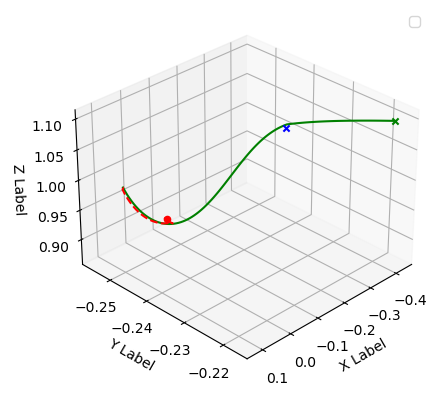

In [25]:
# Move to grasping position
success, idx = run_sim(env, fwd_U, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

# initial joint config
q0 = panda_robot._joint_positions
dq0 = [0]*dof

#Set robot starting position for retrieving trajectory
rbt.set_conf(q0, dq0, False)
obs = env.observation_spec()

print("difference between observed end effector pos and grasping target")
print(rbt.get_ee_pos() - grasps_pos_base)
print(T.quat_distance(rbt.get_ee_orn() , grasps_orn_wxyz))

check_KDL_robosuite_alignement(env, rbt)
# Close gripper
success, idx = run_sim(env, close_gripper_action, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

%matplotlib inline
obs = env.observation_spec()
pos_rob = obs['robot0_eef_pos']
quat_rob = obs['robot0_eef_quat'].copy()
quat_rob = convert_quat(quat_rob, to="wxyz")
rbt_traj = np.array(eef_pos)
fwd_eef_pose = fwd_x_pos[:, 0:3] + base_pos
target1_pos_sim = fwd_target1_pos_base + base_pos
target2_pos_sim = fwd_target2_pos_base + base_pos
plt.title("Planned trajectory")
ax = plt.axes(projection='3d')
ax.plot3D(fwd_eef_pose[:, 0], fwd_eef_pose[:, 1], fwd_eef_pose[:, 2], 'green')
ax.plot3D(rbt_traj[:, 0], rbt_traj[:, 1], rbt_traj[:, 2], 'red', linestyle='dashed')

ax.scatter3D(pos_rob[0], pos_rob[1], pos_rob[2], c='red', marker='o')
ax.scatter3D(target1_pos_sim[0], target1_pos_sim[1], target1_pos_sim[2], c='blue', marker='x')
ax.scatter3D(target2_pos_sim[0], target2_pos_sim[1], target2_pos_sim[2], c='green', marker='x')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.view_init(elev=30, azim=45)
plt.legend()
plt.show()

In [ ]:
# grasps.visualize_grasps(pred_grasps_cam)

## Retrieve

In [ ]:
retrieve_horizon = 70
# initial joint config
#q0 = fwd_jpos[-1]
q0 = panda_robot._joint_positions
dq0 = [0]*dof

#Set robot starting position for retrieving trajectory
rbt.set_conf(q0, dq0, False)

retrieve_target1_pos_base = grasps_pos_base.copy()
retrieve_target1_pos_base -= rotation_mat_grasps[:3,2] * 0.125
retrieve_target1_orn = grasps_orn_wxyz.copy()

retrieve_target2_pos_base = fruits_goal[chosen_fruit].copy() - base_pos
retrieve_target2_pos_base[2] = init_pos[2].copy()
retrieve_target2_orn = init_orn #np.array([-0.1834718, 0.8792443, 0.4396221, 0])

retrieve_target3_pos_base = retrieve_target2_pos_base.copy()
retrieve_target3_pos_base[2] = grasps_pos_base[2]
retrieve_target3_orn = init_orn #target2_orn.copy()

retrieve_Qtarget1 = np.diag([.1, .1, 1, .1, .1, .1])
retrieve_Qtarget2 = np.diag([1, 1, 1, .1, .1, .1])
retrieve_Qtarget3 = np.diag([1, 1, 1, .1, .1, .1])

retrieve_target1_discrete_time = retrieve_horizon//4 - 1
retrieve_keypoint_1 = PosOrnKeypoint(retrieve_target1_pos_base, retrieve_target1_orn,
                                    retrieve_Qtarget1, retrieve_target1_discrete_time)

retrieve_target2_discrete_time = retrieve_horizon - 1
retrieve_keypoint_2 = PosOrnKeypoint(retrieve_target2_pos_base, retrieve_target2_orn,
                                    retrieve_Qtarget2, retrieve_target2_discrete_time)

# retrieve_target3_discrete_time = retrieve_horizon - 1
# retrieve_keypoint_3 = PosOrnKeypoint(retrieve_target3_pos_base, retrieve_target3_orn,
#                                      retrieve_Qtarget3, retrieve_target3_discrete_time)

# retrieve_keypoints = [retrieve_keypoint_1, retrieve_keypoint_2, retrieve_keypoint_3]
retrieve_keypoints = [retrieve_keypoint_1, retrieve_keypoint_2]

# Each control signals have a penalty of 1e-5
cmd_penalties = (np.ones(nb_ctrl_var)*2.5e-5).tolist()

retrieve_sys = PosOrnPlannerSys(rbt,retrieve_keypoints,cmd_penalties,qMax,-qMax,retrieve_horizon,1,dt)

retrieve_u0_t = np.array([0]*(nb_ctrl_var-1) + [0])
retrieve_u0 = np.tile(retrieve_u0_t, retrieve_horizon-1)

mu = retrieve_sys.get_mu_vector(False)
Q = retrieve_sys.get_Q_matrix(False)

retrieve_planner = ILQRRecursive(retrieve_sys)

cb = PythonCallbackMessage()

# solver input :std::vector<VectorXd>& U0, int nb_iter, bool line_search, bool early_stop, CallBackMessage* cb
retrieve_jpos, retrieve_x_pos, retrieve_U, retrieve_Ks, retrieve_ds = retrieve_planner.solve(
                        retrieve_u0.reshape((-1, nb_ctrl_var)), 500, True, True, cb)

retrieve_jpos, retrieve_x_pos = np.asarray(retrieve_jpos), np.asarray(retrieve_x_pos)



In [ ]:
# Go to the right bin
success, idx = run_sim(env, retrieve_U, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

# Open gripper
success, idx = run_sim(env, open_gripper_action, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

check_KDL_robosuite_alignement(env, rbt)

%matplotlib inline

obs = env.observation_spec()
pos_rob = obs['robot0_eef_pos']
quat_rob = obs['robot0_eef_quat'].copy()
quat_rob = convert_quat(quat_rob, to="wxyz")

fwd_eef_pose = fwd_x_pos[:, 0:3] + base_pos
ret_eef_pose = retrieve_x_pos[:, 0:3] + base_pos

target1_pos_sim = retrieve_target1_pos_base + base_pos
target2_pos_sim = retrieve_target2_pos_base + base_pos
target3_pos_sim = retrieve_target3_pos_base + base_pos
grasps_pos_sim = grasps_pos_base + base_pos
rbt_traj = np.array(eef_pos)

plt.title("Planned trajectory")
ax = plt.axes(projection='3d')
# plt.plot(eef_pos_to_world[:,0], eef_pos_to_world[:,1])
ax.plot3D(fwd_eef_pose[:, 0], fwd_eef_pose[:, 1], fwd_eef_pose[:, 2], 'green')
ax.plot3D(ret_eef_pose[:, 0], ret_eef_pose[:, 1], ret_eef_pose[:, 2], 'black', linestyle='dashed')
ax.plot3D(rbt_traj[:, 0], rbt_traj[:, 1], rbt_traj[:, 2], 'red', linestyle='dashed')
ax.scatter3D(pos_rob[0], pos_rob[1], pos_rob[2], c='red', marker='.')
ax.scatter3D(grasps_pos_sim[0], grasps_pos_sim[1], grasps_pos_sim[2], c='red', marker='o')
ax.scatter3D(target1_pos_sim[0], target1_pos_sim[1], target1_pos_sim[2], c='orange', marker='x')
ax.scatter3D(target2_pos_sim[0], target2_pos_sim[1], target2_pos_sim[2], c='cyan', marker='x')
ax.scatter3D(target3_pos_sim[0], target3_pos_sim[1], target3_pos_sim[2], c='green', marker='x')

ax.legend(["foward trajectory", "return trajectory", "robot_pos", "kp_1", "kp_2"])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=30, azim=45)
plt.legend()
plt.show()


## Return

In [ ]:
return_horizon = 50

# initial joint config
# q0 = retrieve_jpos[-1]
q0 = panda_robot._joint_positions
dq0 = [0]*dof

#Set robot starting position for retrieving trajectory
rbt.set_conf(q0, dq0, False)
return_target1_pos_base = fruits_goal[chosen_fruit].copy() - base_pos
return_target1_pos_base[2] = grasps_pos_base[2] + 0.125
return_target1_orn = init_orn
return_target2_pos_base = init_pos
return_target2_orn = init_orn

return_Qtarget1 = np.diag([.1, .1, .4, .1, .1, .1])
return_target1_discrete_time = return_horizon//3 - 1
return_keypoint_1 = PosOrnKeypoint(return_target1_pos_base, return_target1_orn, 
                                return_Qtarget1, return_target1_discrete_time)

return_Qtarget2 = np.diag([1, 1, 1, 1, 1, 1])
return_target2_discrete_time = return_horizon - 1
return_keypoint_2 = PosOrnKeypoint(return_target2_pos_base, return_target2_orn,
                                return_Qtarget2, return_target2_discrete_time)

return_keypoints = [return_keypoint_1, return_keypoint_2]

# Each control signals have a penalty of 1e-5
cmd_penalties = (np.ones(nb_ctrl_var)*10e-5).tolist()

return_sys = PosOrnPlannerSys(rbt, return_keypoints, cmd_penalties, qMax, -qMax,
                            return_horizon,1,dt)

return_u0_t = np.array([0]*(nb_ctrl_var-1) + [0])
return_u0 = np.tile(return_u0_t, return_horizon-1)

mu = return_sys.get_mu_vector(False)
Q = return_sys.get_Q_matrix(False)

return_planner = ILQRRecursive(return_sys)

# callback to notify python code of the solver evolution
cb = PythonCallbackMessage()

# solver input :std::vector<VectorXd>& U0, int nb_iter, bool line_search, bool early_stop, CallBackMessage* cb
return_jpos, return_x_pos, return_U, return_Ks, return_ds = return_planner.solve(
                            return_u0.reshape((-1, nb_ctrl_var)), 500, True, True, cb)

return_jpos, return_x_pos = np.asarray(return_jpos), np.asarray(return_x_pos)

%matplotlib inline
obs = env.observation_spec()
pos_rob = obs['robot0_eef_pos']
quat_rob = obs['robot0_eef_quat'].copy()
quat_rob = convert_quat(quat_rob, to="wxyz")

fwd_eef_pose = fwd_x_pos[:, 0:3] + base_pos
retrieve_eef_pose = retrieve_x_pos[:, 0:3] + base_pos
return_eef_pose = return_x_pos[:, 0:3] + base_pos

return_target1_pos_sim = return_target1_pos_base + base_pos
return_target2_pos_sim = return_target2_pos_base + base_pos
grasps_pos_sim = grasps_pos_base + base_pos

plt.title("Planned trajectory")
ax = plt.axes(projection='3d')
# plt.plot(eef_pos_to_world[:,0], eef_pos_to_world[:,1])
ax.plot3D(fwd_eef_pose[:, 0], fwd_eef_pose[:, 1], fwd_eef_pose[:, 2], 'green')
ax.plot3D(retrieve_eef_pose[:, 0], retrieve_eef_pose[:, 1], retrieve_eef_pose[:, 2], 'black', linestyle='dashed')
ax.plot3D(return_eef_pose[:, 0], return_eef_pose[:, 1], return_eef_pose[:, 2], 'blue', linestyle='dashed')
ax.scatter3D(pos_rob[0], pos_rob[1], pos_rob[2], c='red', marker='.')
ax.scatter3D(grasps_pos_sim[0], grasps_pos_sim[1], grasps_pos_sim[2], c='red', marker='o')
ax.scatter3D(return_target1_pos_sim[0], return_target1_pos_sim[1], return_target1_pos_sim[2], c='orange', marker='x')
ax.scatter3D(return_target2_pos_sim[0], return_target2_pos_sim[1], return_target2_pos_sim[2], c='cyan', marker='x')

ax.legend(["foward trajectory", "return trajectory", "robot_pos", "kp_1", "kp_2"])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=30, azim=45)
plt.legend()
plt.show()


In [ ]:
check_KDL_robosuite_alignement(env, rbt)
# Return to pos
success, idx = run_sim(env, return_U, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

# Simulate and render

In [ ]:
# # Show agentview image, depth and segmap in opencv windows
# show=False

# eef_pos, eef_quat = [], []
# obs = env.observation_spec()
# eef_pos.append(obs['robot0_eef_pos'])
# eef_quat.append(obs['robot0_eef_quat'])

# close_gripper_action = np.zeros((20,dof))
# close_gripper_action[:,-1] = 0.3

# open_gripper_action = np.zeros((20,dof))
# open_gripper_action[:,-1] = -0.3

# # Move to grasping position
# success, idx = run_sim(env, fwd_U, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

# # initial joint config
# q0 = panda_robot._joint_positions
# dq0 = [0]*dof
# #Set robot starting position for retrieving trajec
# # tory
# rbt.set_conf(q0, dq0, False)
# print("end effector from KDL forward kinematic")
# print(rbt.get_ee_pos())
# print(rbt.get_ee_orn())

# obs = env.observation_spec()
# print("end effector from robosuite observation")
# print(obs['robot0_eef_pos'] - base_pos)
# print(obs['robot0_eef_quat'])

# print("fruit grasping pose")
# print(grasps_pos_base)
# print(fruit_orn)

# print("difference")
# print(rbt.get_ee_pos() - grasps_pos_base)
# print(T.quat_distance(rbt.get_ee_orn() , fruit_orn))

# #grasps.visualize_grasps(pred_grasps_cam)

# # Close gripper
# success, idx = run_sim(env, close_gripper_action, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

# # Go to the right bin
# success, idx = run_sim(env, retrieve_U, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

# # Open gripper
# success, idx = run_sim(env, open_gripper_action, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

# # Return to pos
# success, idx = run_sim(env, return_U, eef_pos=eef_pos, eef_quat=eef_quat, segmentation_type=segmentation_type, show_agentview=show)

In [ ]:
# check_KDL_robosuite_alignement(env, rbt)

In [ ]:
# obs = env.observation_spec()
# pos_rob = obs['robot0_eef_pos']
# quat_rob = obs['robot0_eef_quat'].copy()
# quat_rob = convert_quat(quat_rob, to="wxyz")

# fwd_eef_pose = fwd_x_pos[:, 0:3] + base_pos
# retrieve_eef_pose = retrieve_x_pos[:, 0:3] + base_pos
# return_eef_pose = return_x_pos[:, 0:3] + base_pos

# grasps_pos_sim = grasps_pos_base + base_pos
# eef_pos = np.array(eef_pos)

# plt.title("Planned trajectory")
# ax = plt.axes(projection='3d')
# # plt.plot(eef_pos_to_world[:,0], eef_pos_to_world[:,1])
# ax.plot3D(fwd_eef_pose[:, 0], fwd_eef_pose[:, 1], fwd_eef_pose[:, 2], 'green')
# ax.plot3D(retrieve_eef_pose[:, 0], retrieve_eef_pose[:, 1], retrieve_eef_pose[:, 2], 'black', linestyle='dashed')
# ax.plot3D(return_eef_pose[:, 0], return_eef_pose[:, 1], return_eef_pose[:, 2], 'blue', linestyle='dashed')
# ax.plot3D(eef_pos[:, 0], eef_pos[:, 1], eef_pos[:, 2], 'red', linestyle='dashed')

# ax.scatter3D(pos_rob[0], pos_rob[1], pos_rob[2], c='red', marker='.')
# ax.scatter3D(grasps_pos_sim[0], grasps_pos_sim[1], grasps_pos_sim[2], c='red', marker='o')

# ax.legend(["foward trajectory", "return trajectory", "robot_pos", "kp_1", "kp_2"])
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# ax.view_init(elev=30, azim=45)
# plt.legend()
# plt.show()


In [ ]:
# grasps.visualize_grasps(pred_grasps_cam)

# Test, go directly there without simulating movement

In [ ]:

# fwd_jpos[-1]

# pos = fwd_jpos[-1]
# pos[-1] = 0.74152
# panda_robot.set_robot_joint_positions(pos)

# # Closing grasps

# for i in range(2):
#     action = np.zeros(dof)
#     env.step(action)
#     env.viewer.set_camera(camera_id=3)
#     env.render()



# print("Difference between simulation and pos expected from iLQR:\n", panda_robot._hand_pos-rbt.get_ee_pos())
# print("Difference between simulation and pos expected from contact graspnet:\n", panda_robot._hand_pos-target2_pos_base)


# for i in tqdm(range(10)):
#     action = np.zeros(dof)
#     action[-1] = 0.5j
#     obs, reward, done, _ = env.step(action)
#     env.render()
    
# grasps.visualize_grasps(pred_grasps_cam)
# # moving fruit upward and shaking

# for i in tqdm(range(retrieve_horizon-1)):
#     action = retrieve_U[i]
#     obs, reward, done, _ = env.step(action)
#     env.render()


# for i in tqdm(range(return_horizon - 1)):
#     action = return_U[i]
#     obs, reward, done, _ = env.step(action)
#     env.render()
